# En este proyecto intentaremos predecir el género de una película dado el plot en inglés de la misma.

### Carga de datos y limpieza general

Comenzamos importando las librerias

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.utils import shuffle

Descargamos el dataset de Kaggle de este link: https://www.kaggle.com/jrobischon/wikipedia-movie-plots ... Adicionalmente, revisaremos brevemente la información que contiene el DataSet

In [3]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')

In [4]:
display(df.head(2))
display(df.shape)
display(df["Genre"].value_counts().head())
display("Unique genres values: {}".format(len(df["Genre"].value_counts())))

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."


(34886, 8)

unknown    6083
drama      5964
comedy     4379
horror     1167
action     1098
Name: Genre, dtype: int64

'Unique genres values: 2265'

Vemos que hay muchos generos desconocidos y que hay una variedad muy grande de géneros (2265), por ello decido
traerme otro DataFrame de IMDB con los géneros y posteriormente hacer un join. 


In [5]:
# Importamos el nuevo dataframe  
df_genre = pd.read_csv("title.basics.tsv",delimiter="\t")

In [6]:
# Revisamos la información que nos trae el nuevo DataFrame
display(df_genre.head(3))
df_genre.shape

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"


(5463542, 9)

In [264]:
# Hacemos el Merge 
df_joined = df.merge(df_genre[["originalTitle","genres"]],left_on="Title",right_on="originalTitle").sample(80000,random_state=42)


Revisamos la información que tenemos

In [265]:
display("Forma del nuevo df: {}".format(df_joined.shape))

display("Cantidad de películas únicas en el df: {}".format(len(df_joined["Title"].unique().tolist())))

jack = len(df_joined[df_joined["Title"]=="Jack and the Beanstalk"])
display("Hay películas repetidas, por ejemplo, 'Jack and the Beanstalk' aparece {} veces".format(jack))

df_joined[df_joined["Title"] == "Jack and the Beanstalk"][["Title","genres"]].head()

'Forma del nuevo df: (80000, 10)'

'Cantidad de películas únicas en el df: 15396'

"Hay películas repetidas, por ejemplo, 'Jack and the Beanstalk' aparece 22 veces"

,Title,genres
41,Jack and the Beanstalk,"Animation,Comedy"
44,Jack and the Beanstalk,"Family,Short"
89,Jack and the Beanstalk,\N
87,Jack and the Beanstalk,"Family,Short"
12,Jack and the Beanstalk,\N


In [266]:
# Nos quedamos únicamente con las features que nos interesan.
df_joined_c = df_joined.loc[:,("Title","Plot","genres")]

# Eliminamos las películas que no tienen un género asignado y las filas que están duplicadas.
df_joined_c = df_joined_c[df_joined_c.loc[:,"genres"] !="\\N"]
df_joined_c.drop_duplicates(inplace=True)
display(df_joined_c.shape)
df_joined_c.head(3)

(60950, 3)

,Title,Plot,genres
186486,Kidnap,"Karla Dyson (Halle Berry), a diner waitress, l...","Crime,Drama,Mystery"
105303,Finders Keepers,Con man Michael Rangeloff (Michael O'Keefe) is...,Game-Show
3016,The Cheat,Socialite Edith Hardy (Ward) has extravagant t...,"Drama,Short"


Ya que existen películas que aparecen repetidas muchas veces con distintos géneros asignados (como Jack and the Beanstalk), decido quedarme con el género que más veces aparece repetido por película.

In [267]:
new_df = []
def genres(movie):  
    genres = df_joined_c[df_joined_c["Title"]== movie]["genres"].tolist() # List of genres
    title = df_joined_c[df_joined_c["Title"]== movie]["Title"].iloc[0] # title
    plot = df_joined_c[df_joined_c["Title"]== movie]["Plot"].iloc[0] # plot
    list_genres = (",".join(genres)).split(",") # genres in list 
    genres_proc = pd.Series(list_genres).value_counts().index[:1].tolist() # Top 2 most repeated genres
    inf = {"Title":title,"Plot":plot,"Genres":genres_proc} # Final row to add
    new_df.append(inf)

In [268]:
%%time
unique_titles = df_joined_c["Title"].unique().tolist()
for title in unique_titles:
    genres(title)

CPU times: user 8min 57s, sys: 5.22 s, total: 9min 2s
Wall time: 13min


In [225]:
movies = pd.DataFrame(new_df)
movies.head(3)

,Genres,Plot,Title
0,[Drama],"Karla Dyson (Halle Berry), a diner waitress, l...",Kidnap
1,[Drama],Con man Michael Rangeloff (Michael O'Keefe) is...,Finders Keepers
2,[Drama],Socialite Edith Hardy (Ward) has extravagant t...,The Cheat


### Análisis sobre los géneros

In [226]:
genres_array = np.array([])
for i in range(0,len(movies)):
    genres_array = np.concatenate((genres_array, movies['Genres'][i]))


In [228]:
# Lets see thow many movies we have for each genre
gen_df = pd.DataFrame({"Genres":genres_array})
gen_df["Count"] = 1 
mbg = gen_df.groupby("Genres").sum().sort_values(by="Count",ascending=False)
mbg.head

<bound method NDFrame.head of              Count
Genres            
Drama         3702
Comedy        3526
Short         1115
Crime          935
Documentary    904
Adventure      857
Romance        584
Thriller       503
Animation      498
Family         475
Horror         458
Mystery        441
Action         400
Talk-Show      340
Fantasy        306
Western        288
Biography      255
War            218
Music          183
Musical        162
Adult          129
History        119
Reality-TV     119
Sci-Fi          89
Sport           86
News            62
Film-Noir       17
Game-Show        7>

Vemos que la mayoría de las películas pertenecen a unos pocos géneros. Así mismo que el género "Music" y "Musical" se puede agrupar. 

In [229]:
# Transformamos "Music" en "Musical"
gen_df["Genres"] = gen_df["Genres"].apply(lambda x: "Musical" if x == "Music" else x)
mbg2 = gen_df.groupby("Genres").sum().sort_values(by="Count",ascending=False)

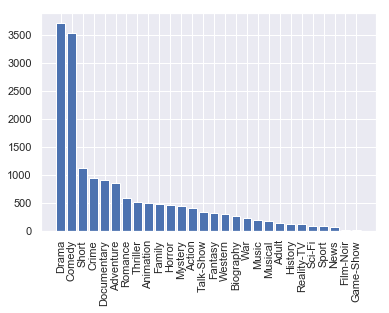

In [230]:
# Creamos un gráfico visual
sns.set()
_ = plt.bar(mbg.index,mbg["Count"],label=mbg.index)
plt.xticks(rotation=90)
plt.show()

In [231]:
# Creamos una tabla de frequencia de distribución para quedarnos con los géneros que incluyen el 95% de los datos.
gen_freq = mbg2.reset_index()
gen_freq["Frequency"] = gen_freq["Count"]/len(gen_df)
gen_freq["Cumulative_Freq"] = gen_freq["Frequency"].cumsum()
gen_freq

,Genres,Count,Frequency,Cumulative_Freq
0,Drama,3702,0.220646,0.220646
1,Comedy,3526,0.210156,0.430802
2,Short,1115,0.066456,0.497258
3,Crime,935,0.055728,0.552986
4,Documentary,904,0.053880,0.606866
5,Adventure,857,0.051079,0.657945
6,Romance,584,0.034807,0.692752
7,Thriller,503,0.029980,0.722732
8,Animation,498,0.029682,0.752414
9,Family,475,0.028311,0.780725


Ya que conocemos los géneros principales, filtremos nuestro dataframe original. Recordemos que debemos también
sustituir "Music" por "Musical" en nuestos datos originales. En un primer intento de la clasificacion de los generos con los algoritmos de sklearn, ocurre que me está clasificando todas las películas como Drama o como Comedia, es por ello que vamos a disminuir la cantidad de películas seleccionadas de esos géneros para quitarles preponderancia. Adicionalmente, decido eliminar el genero "Short" ya que analizando sus plots no hay nada que los distinga del resto de los generos y esto puede disminuir la precision del modelo.

In [232]:
# Filtramos los generos que incluyen el 90% de los datos.
top_genres = np.array(["Comedy","Horror","Crime"])
#top_genres = np.array(gen_freq[(gen_freq["Cumulative_Freq"]<=0.85) & ( gen_freq["Genres"]!= "Short")]["Genres"])

In [233]:
movies["Genres"] = movies["Genres"].apply(lambda x: ["Musical" if word =="Music" else word for word in x])
movies['Genres_split'] = movies["Genres"].apply(lambda x: x[0])
movies = movies[movies["Genres_split"].isin(top_genres)]
movies

,Genres,Plot,Title,Genres_split
8,[Horror],A small ship travels to a rotating space stati...,Warning from Space,Horror
13,[Comedy],"""Clay Bidwell"" is a young man in a small town ...",Clay Pigeons,Comedy
14,[Comedy],"In the small town of Mercury, New Mexico (film...",Independence Day,Comedy
18,[Crime],Millionaire businessman-sportsman Thomas Crown...,The Thomas Crown Affair,Crime
35,[Comedy],An introductory montage shows the fallout of t...,Red Dawn,Comedy
37,[Crime],After a showgirl is found murdered shortly aft...,The Long Dark Hall,Crime
38,[Comedy],Ashok's (Prakash Raj) brothers smuggle drugs a...,Alexander,Comedy
39,[Horror],"In the small mining village of Kitamatsu, on t...",Rodan,Horror
49,[Comedy],"In their prime, Pittsburgh boxers Henry ""Razor...",Grudge Match,Comedy
56,[Crime],Harry Sterndale (Chris Rea) is told that he ha...,Parting Shots,Crime


In [234]:
max_cantidad = (movies["Genres_split"].value_counts()).min()
new_movies = pd.DataFrame()

for genre in top_genres:
    filtrado_por_genero = movies[movies["Genres_split"]==genre]
    genero = (filtrado_por_genero.sample(min(len(filtrado_por_genero),int(max_cantidad))))
    new_movies = new_movies.append(genero)



In [235]:
# Vemos que ahora la cantidad de películas por géneros está más balanceado
pd.DataFrame(new_movies["Genres_split"].value_counts())

,Genres_split
Comedy,458
Crime,458
Horror,458


Convirtamos a valores numéricos los géneros de las películas.Esto lo hacemos para preparar la información para el momento de la clasificación, ya que los algoritmos no entienden de palabras si no de valores numéricos.

In [236]:
le = preprocessing.LabelEncoder()
labels = le.fit_transform(new_movies["Genres_split"])
new_movies["Genres_Label"] = labels
movies_cleaned = new_movies[["Plot","Genres_Label"]]

In [237]:
# Mezclamos un poco los datos para que no esten ordenados al momento de aplicar al algoritmo.
movies_cleaned = shuffle(movies_cleaned)
movies_cleaned.head()

,Plot,Genres_Label
16038,"A man John ""Son"" Martin makes moonshine whiske...",1
381,New York oil magnate Ben Richards (Charles Win...,0
9855,"Barkley ""Bark"" (Victor Moore) and Lucy Cooper ...",0
4896,"Marcus (Xavier Samuel), his best friend Craig ...",2
13011,"Salvatore Giuliano, the infamous bandit, toget...",1


Utilicemos OneHotEncoding para transformar los géneros en columnas con unos y ceros dependiendo de si el género corresponde a esa película o no respectivamente. Esto lo hacemos ya que los algoritmos no entienden de palabras si no de valores numéricos

In [238]:
# movies = pd.concat([movies, movies.Genres.apply(lambda x: ','.join(x)).str.get_dummies(sep=',')], axis=1)

In [239]:
# movies_cleaned = movies.drop(["Genres","Genres_str"],axis=1)
# movies_cleaned.head(3)

### Limpieza de los plots

Comenzamos por crear una serie de funciones que nos permitirán limpiar los plots. Lemmatize convierte distintas palabras de igual significado en la misma, luego las regular expressions y RemoveCharDigit se quedan solo con palabras eliminando números y caractéres especiales, así como conviertiendo palabras compuestas en palabras separadas. 

In [240]:
stop_words = stopwords.words("english")
Stop_word_TryAndError = ["ha","wa","one","get","take","go","back","tell","two","make","see","come","hi","tri","him",'thi',"onli","him","also","later"]
lemma=WordNetLemmatizer()
token=ToktokTokenizer()
stemmer = PorterStemmer()

In [241]:
def lemitizeWords(text):
    listLemma = []
    words=token.tokenize(text)
    stem = [stemmer.stem(word) for word in words]
    for w in stem:
        x=lemma.lemmatize(w)
        listLemma.append(x)
    return listLemma

def stopWordsRemove(text):
    wordList =[x.lower().strip() for x in token.tokenize(text)]
    removedList=[x for x in wordList if x not in stop_words and x not in Stop_word_TryAndError]
    text=" ".join(removedList)
    return text

def removeCharDigit(text):
    str="1234567890-=~@#$%^&*()_+[!{;”:\’><.,/?”}]"
    for w in text:
        if w in str:
            text=text.replace(w,"")
    return text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

def PreProcessing(text):
    text = lemitizeWords(text)
    text = stopWordsRemove(text)
    text = clean_text(text)
    text = removeCharDigit(text)
    
    return(text)


In [346]:
def preprocessing2(x):
    alo = nltk.FreqDist([word for word in x.split()]).most_common(100)
    return " ".join([ word[0] for word in alo])

In [287]:
ejemplo = " ".join(movies_cleaned[["Plot"]].iloc[9].tolist())
print("Por ejemplo, la frase: {}".format(ejemplo))
print("\nSe convierte en:")
print("\n{}".format(PreProcessing(ejemplo)))

Por ejemplo, la frase: The movie begins with Kate discussing her mother Lori's series of bad relationships which always caues them to move to a new town. She and her mother move to a suburb of Portland, Oregon and Kate gets a job as a waitress. While at work, she sees popular local boy John Tucker on dates with three different girls: Carrie, a chronic overachiever; Heather, who is head cheerleader; and Beth a promiscuous and liberal vegan activist. Kate learns from a co-worker that he dates girls from different cliques at his school so that they never interact and convinces the girls he dates to keep their relationships secret.
One day in gym class, Kate, Carrie, Heather and Beth end up on the same team for a volleyball game. During the game, Carrie brags about being with John Tucker, and the girls learn about his scheme. Carrie, Heather and Beth begin fighting. Kate tries to intervene, only to get all four of them sent to detention for the fight. Later that evening, the girls enlist K

In [288]:
# Apliquemos la funcion a todos los plots. 
movies_cleaned["plot_cleaned"] = movies_cleaned["Plot"].apply(lambda x : PreProcessing(x)).apply(lambda x: preprocessing2(x))

### Análisis de las palabras de los plots 

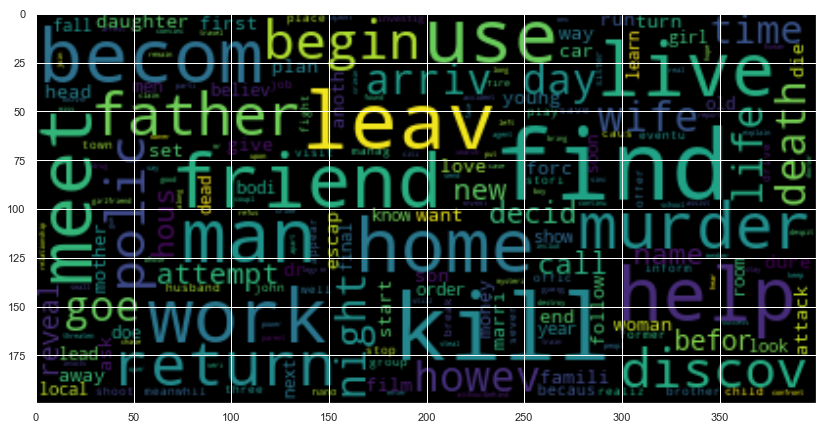

In [289]:
totalText=""
for words in movies_cleaned["plot_cleaned"]:
    totalText += words

wc=WordCloud(background_color="black",max_font_size=50).generate(totalText)
plt.figure(figsize=(14,12))
plt.imshow(wc, interpolation="bilinear")

### Frecuencia con la que aparecen las palabras 

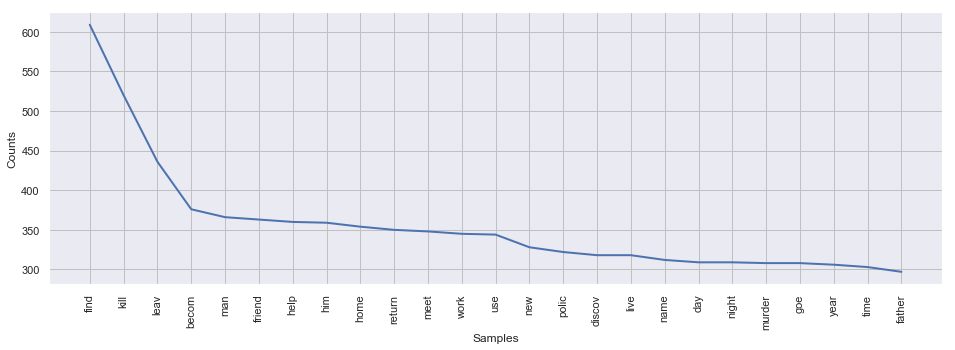

In [283]:
x=nltk.FreqDist(ToktokTokenizer().tokenize(totalText))

plt.figure(figsize=(16,5))
x.plot(25)

Modifiquemos las palabras con one hot encoding, para ello utilizamos CountVectorier y TfidfTransformer

In [290]:
encode = movies_cleaned.loc[:,"plot_cleaned"]
cv= CountVectorizer().fit(encode)
count_vect = pd.DataFrame(cv.transform(encode).todense(),columns=cv.get_feature_names())
tfidfhead=TfidfTransformer().fit(count_vect)
transformed =pd.DataFrame(tfidfhead.transform(count_vect).todense(),columns=cv.get_feature_names())

### Clasificacion - Entrenamiento y prueba de modelos 

In [291]:
X = transformed
y = movies_cleaned["Genres_Label"]

#### Random Forrest with GridSearch and 5 CVF. 

In [163]:
# Random Forest Classifier 
param_grid = {"n_estimators" : [50,100,150]}
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf,param_grid,cv=5)
rf_cv.fit(X,y)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'n_estimators': 100}
0.6468155500413565


### Probamos con 3 modelos a ver los resultados. 

In [292]:
Linear_SVC = LinearSVC()
Logistic_Regression = LogisticRegression()
Gaussian_NB = GaussianNB()

clasificadores = {"Linear_SVC":Linear_SVC,"Logistic_Regression":Logistic_Regression,"Gaussian_NB":Gaussian_NB}

for k,v in clasificadores.items():
    cv_results = cross_val_score(v,X,y,cv=5)
    print('Clasificador: {}, Accuracy:{}'.format(k,np.mean(cv_results)))


Clasificador: Linear_SVC, Accuracy:0.6747412008281574
Clasificador: Logistic_Regression, Accuracy:0.6951106864150344
Clasificador: Gaussian_NB, Accuracy:0.5123825449912406


In [293]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

In [294]:
def confusionMatrixHeatmap(cm, labels):
    totals = cm.sum(axis=1)
    cm_total = (np.ones(cm.shape)*totals).transpose()
    m2 = np.round(((cm/cm_total)*100).astype(float))
    np.set_printoptions(precision=2)
    f, ax=plt.subplots(figsize=(7.5,5))
    sns.heatmap(m2, annot=True, linecolor='white', linewidths=0.2,
                xticklabels=labels, yticklabels=labels)
    ax.set_title('CONFUSION MATRIX')
    plt.xlabel('Classified as')
    plt.ylabel('Real Values')

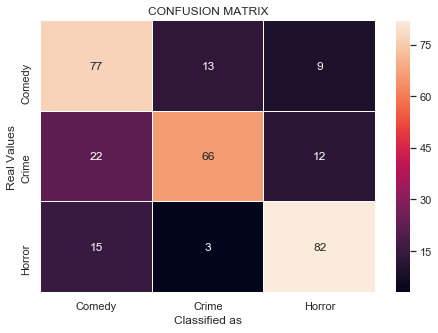

In [295]:
labels_mov = le.inverse_transform(list(set(labels))).tolist()
cm2 = confusionMatrixHeatmap(cm,labels_mov)
cm2


Conclusión: Obtenemos una precisión del 70% aproximadamente, lo cual no está tan mal, vemos que donde más se equivoca el clasificador es con la comedia ... probemos varios plots a ver que obtenemos. 

In [424]:
# Book Club -
comedia = "Four longtime friends and book club members Diane Keaton, Jane Fonda, Candice Bergen and Mary Steenburgen have their lives upended when they aim to spice up their mundane routines by reading the provocative bestseller Fifty Shades of Grey. With newfound confidence, they each begin to come alive as exciting romances are ignited and old flames are rekindled. Through it all, the ladies inspire one other to make this next stage of their lives the best and steamiest thus far."
# The Spy Who Dumped Me - 
comedia2  = "Audrey (Mila Kunis) and Morgan (Kate McKinnon), two thirty-year-old best friends in Los Angeles, are thrust unexpectedly into an international conspiracy when Audrey’s ex-boyfriend shows up at their apartment with a team of deadly assassins on his trail. Surprising even themselves, the duo jump into action, on the run throughout Europe from assassins and a suspicious-but-charming British agent, as they hatch a plan to save the world."

# Den of Thieves - 
crimen = "A gritty crime saga which follows the lives of an elite unit of the LA County Sheriff's Dept. and the state's most successful bank robbery crew as the outlaws plan a seemingly impossible heist on the Federal Reserve Bank."
# Gladiator - El gladiador 
crimen2 = "A former Roman General sets out to exact vengeance against the corrupt emperor who murdered his family and sent him into slavery."

# The num - La monja
horror = "A priest with a haunted past and a novice on the threshold of her final vows are sent by the Vatican to investigate the death of a young nun in Romania and confront a malevolent force in the form of a demonic nun."
horror_larga = "In 1952 Romania, two Roman Catholic nuns living at the Saint Cartha's monastery are attacked by an unseen force when they enter a tunnel to retrieve an ancient Christian relic. The surviving nun, Sister Victoria, flees from the attacker, a demon appearing as a nun, and hangs herself. Her body is discovered by Frenchie, a villager who transports supplies to the nuns. The Vatican learns of the incident and summons Father Burke to Rome, where they ask him to travel with Sister Irene, a nun in her novitiate, to Romania in order to investigate the situation. While Sr. Irene is teaching children the relationship between religion and science in a school, her Mother Superior interrupts her and informs her that Burke has arrived in order to request Irene's accompaniment in his trip to Romania. The pair travel to Romania and meet with Frenchie, who leads them to the abbey. They discover Victoria's body and remove a key from her corpse. Inside, they encounter the Abbess, who informs them that the nuns observe a period of silence during the night and offers them lodging at the attached convent if they wish to return the next day. Frenchie is attacked by a demon as he returns to the village, but escapes. Burke tells Irene that a boy he exorcised, Daniel, was fatally injured during the exorcism, and Burke has carried the burden of the boy's death with him ever since. Irene reveals that as a girl, she had visions particularly of a nun, causing the Church to take an interest in her. Burke is rescued by Irene after being buried alive in the graveyard by the demonic entity.."
# Hereditary - El legado del diablo
horror2 = "After the family matriarch passes away, a grieving family is haunted by tragic and disturbing occurrences, and begin to unravel dark secrets."
# The rite - El rito
horror3 = "An American seminary student travels to Italy to take an exorcism course."
horror3_larga = "Michael, the son of a funeral director grows indifferent to his father and joins a Seminary. On his way to the course completion, he is overwhelmed by a strong lack of faith. His religious beliefs are further jolted when he sees a young girl haplessly dying in a road accident for whom he reluctantly performs the ritual to absolve her sins. His mentor still believes in him and urges him to go to Italy to take an exorcism course hoping that he it would strengthen his faith in Christianity. In Italy he attends a session from Father Xavier who soon becomes aware of his skepticism. As a result he sends him to an eminent Jesuit exorcist, Father Lucas, whose ways though questionable are quite effective. He witnesses the exorcism of a sixteen year old girl but still seems unconvinced. Father Lucas explains to him that it takes multiple sessions over a long stretch of time to completely free a victim from the demon. Despite witnessing some supernatural occurrences during the aforesaid exorcism, Michael is as skeptical as ever. After the second exorcism, the girls condition becomes quite critical as she is moved to a hospital. She soon dies and the demon finds a new victim. As the moment of reckoning draws near, Micheal may be the only hope left but first he must overcome his own doubts and apprehensions in order to fight and destroy the ominous forces"





In [425]:
def conv_pelicula(x): 
    return preprocessing2(PreProcessing(x))


In [426]:
lista = conv_pelicula(horror3_larga)
palabras = np.array(X.columns)
vacia = []
for palabra in palabras:
    if palabra in lista:
        vacia.append(1)
    else:
        vacia.append(0)

In [427]:
vacia = np.array(vacia)
prueba2 = vacia.reshape(1,-1)

In [428]:
clf = LogisticRegression().fit(X,y)

pd.DataFrame(clf.predict_proba(prueba2),columns=le.inverse_transform(list(set(labels))))

,Comedy,Crime,Horror
0,0.036754,0.003553,0.959693


44

Probamos con distintos clasificadores con distintas estrategias de multiclasificacion

In [ ]:
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())
classifier.fit(xtrain.astype(float), ytrain.astype(float))
predictions = classifier.predict(xtest.astype(float))
accuracy_score(ytest.astype(float),predictions)

In [ ]:


# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(xtrain.astype(float), ytrain.astype(float))

# predict
predictions = classifier.predict(xtest.astype(float))
accuracy_score(ytest.astype(float),predictions)

In [ ]:
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifierfrom skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(GaussianNB())
classifier.fit(xtrain.astype(float), ytrain.astype(float))
predictions = classifier.predict(xtest.astype(float))
accuracy_score(ytest.astype(float),predictions)

In [ ]:
clf=OneVsRestClassifier(MultinomialNB())
clf.fit(x,y)
pred=clf.predict(x)
accuracy_score(y,pred)

## Lets Split our data between train and test and test some classifiers

In [ ]:
# LogReg_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words,ngram_range=(1,3))),
#                 ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
#             ])
TOKENS_ALPHANUMERIC = "[A-Za-z0-9]+(?=\\s+)"

LogReg_pipeline = Pipeline([
                ('vec', CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC,ngram_range=(1,3))),
                ("int", SparseInteractions(degree=2)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train, y_train)
prediction = LogReg_pipeline.predict_proba(X_test)
pd.DataFrame(prediction)

In [ ]:
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))

In [ ]:
rf = Pipeline([
                ('vec', CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC,ngram_range=(1,3))),
                ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=10), n_jobs=1)),
            ])

rf.fit(X_train, y_train)
prediction = rf.predict_proba(X_test)
pd.DataFrame(prediction)

In [ ]:
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    rf.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = rf.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))

In [ ]:
X = movies_cleaned.loc[:,"Plot_cleaned"]
y = movies_cleaned.iloc[:,3:-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)
X_train.shape , X_test.shape, y_train.shape , y_test.shape

In [ ]:
1 - len(y_test[y_test["Action"]==1])/len(y_test)

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train, y_train)
prediction = LogReg_pipeline.predict_proba(X_test)
pd.DataFrame(prediction)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', RandomForestClassifier()),
            ])

rf.fit(X_train, y_train)
accuracy = rf.score(X_test, y_test)
accuracy

# prediction = rf.predict_proba(X_test)
# pd.DataFrame(prediction)

In [ ]:
contador_LR = 0    
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
    contador_LR += accuracy_score(y_test[genre], prediction)

## SVC

In [ ]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
            ])

SVC_pipeline.fit(X_train, y_train)


La primera vez que hago el SVC e imprimo las matrices de confusion veo que hay colu

In [ ]:
contador_svc = 0    
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
    contador_svc += accuracy_score(y_test[genre], prediction)

# SVC_pipeline.fit(X_train, y_train["Drama"])
# prediction = SVC_pipeline.predict(X_test)
# display(accuracy_score(y_test["Drama"], prediction))
# display(confusion_matrix(y_test["Drama"], prediction))
# print(classification_report(y_test["Drama"], prediction))
                 

## LogisticRegression 

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


In [ ]:
contador_LR = 0    
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
    contador_LR += accuracy_score(y_test[genre], prediction)

In [ ]:
MultinomialNB = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])


In [ ]:
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    MultinomialNB.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = MultinomialNB.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))
    print(classification_report(y_test[genre], prediction))
